# Presentation

#### Goal: Predict the number of nights granted to a request (not to an individual)


#### Caracteristics of the model:
Accuracy:
- if used as a clearing tool removing overburden upfront, and thus only to get rid of obvious cases, the accuracy of such a tool could be its most important caracteristic.

Interpretability:
- could help families understand the decision (although not as important as in diseases predictions).
- can also highlight and thus control biases (racial, sex, age).
- since the tool would probably be used in combination with human selection, it could help save time by highlighting the main factors for each decision

#### Conclusion:
- a model easily interpretable could be prefered (tree).
- or a highly accurate model (less interpretable) could also be used upfront (NN).


#### Future improvements

Imputations:
- Build more robust, generalisable imputations (eg. impute future test samples with missing gender based on all easily interpretable categories group_composition_label and group_composition_id)

- Automate NaNs imputation for future test samples

- Reconstruct some NaNs by training models to predict the feature

# Plan

I. Load

1. Packages, classes, functions

2. Databases and Join

II. Pre-process data 1:

1. Impute NaNs

2. Remove outliers

III. Analyze

1. Impact on target

2. Correlated features

IV. Pre-process data 2:

1. Transform categorical features

V. Build Model

1. Benchmakrs

2. Rush model using all data

3. Simple using principal components

4. More complex using specific features

5. Ensemble

VI. Predictions

1. Train and Predict

2. Hyperparameter tunning (split train set)

VII. Evaluate methods


# Classes, Functions & imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import log_loss
from sklearn import tree

#os.chdir('/Users/Pro/Desktop/Git_Contests/Predictions/Emergency_housing/')
from cobratools import Analysis

In [2]:
# Define the test scorer
def competition_scorer(y_true, y_pred):
    return log_loss(y_true, y_pred, sample_weight=10**y_true)

In [3]:
# General constants
USE_PRE_PROCESSED_DATA = False
PRINT_ON = True
PLOT_ON = True

## Load data

In [4]:
if not USE_PRE_PROCESSED_DATA:

    requests_train = pd.read_csv(filepath_or_buffer='data/requests_train.csv',
                                sep=',',
                                low_memory=False,
                                error_bad_lines=False)

    requests_test = pd.read_csv(filepath_or_buffer='data/requests_test.csv',
                                sep=',',
                                low_memory=False,
                                error_bad_lines=False)

    individuals_train = pd.read_csv(filepath_or_buffer='data/individuals_train.csv',
                                    sep=',',
                                    low_memory=False,
                                    error_bad_lines=False)

    individuals_test = pd.read_csv(filepath_or_buffer='data/individuals_test.csv',
                                sep=',',
                                low_memory=False,
                                error_bad_lines=False)

else:
    df_train = pd.read_csv(filepath_or_buffer='data/data_train_preprocessed.csv',
                                sep=',',
                                index_col='individual_id',
                                low_memory=False)

    df_test = pd.read_csv(filepath_or_buffer='data/data_test_preprocessed.csv',
                                sep=',',
                                index_col='individual_id',
                                low_memory=False)

## Join datasets

Since there are multiple requests by individuals and multiple individuals by request, the straightfoward approach would be to create columns for each individual' informations. This way, no information would be lost, but the curse of dimensionality is very near and the number of samples might be too low to extract useful information.

The chosen approach is rather to only keep the request dataset' columns, and feature engineer additional columns based on the individuals data, eg.:
- nb of past requests made by the same individual
- nb nights granted in past requests of the same individual(s)/group
- gender diversity of the group
- etc.

In [5]:
df_train = pd.merge(requests_train, individuals_train, on='request_id', how='outer')
df_test = pd.merge(requests_test, individuals_test, on='request_id', how='outer')
del requests_train, requests_test
del individuals_train, individuals_test

# Set index col as individual id
#df_train.set_index('individual_id', inplace=True)
#df_test.set_index('individual_id', inplace=True)
# Set index col as request id
df_train.set_index('request_id', inplace=True)
df_test.set_index('request_id', inplace=True)

## Instanciate object analysis

In [6]:
# Instanciate analysis object
analyze_train = Analysis(df_train)
analyze_test = Analysis(df_test)
del df_train
del df_test

# Define properties
target = 'granted_number_of_nights' 
analyze_test.target = target
analyze_train.target = target
n_samples_train = analyze_train.df.shape[0]
n_samples_test = analyze_test.df.shape[0]

In [7]:
sum(analyze_train.df.index.duplicated())

300620

# Pre-process data 1

## Impute NaNs

Methodology:
- inspect NaNs on train set

- if pattern detected, apply modifications on train and test sets

Observations:
- reverse engineering: the system seems to derive group_composition_id from group_composition_label, and both are then necessary linked/redondant => drop group_composition_label

- there can be multiple individuals by request, and multiple requests by individual

### NaNs train summary

Train: NaNs count by feature

 child_to_come                    232192
housing_situation_label           23309
long_term_housing_request        263872
town                             253287
victim_of_violence_type          377088
childcare_center_supervision     378254
disabled_worker_certification    254741
gender                                1
individual_creation_date          19700
individual_role                  301043
individual_role_2_label              55
marital_status_label             102338
pregnancy                            14
dtype: int64


Test: NaNs count by feature

 child_to_come                    57361
group_composition_label              1
group_creation_date                  1
group_type                           1
housing_situation_label           5858
long_term_housing_request        65347
town                             62547
victim_of_violence                   1
victim_of_violence_type          93988
childcare_center_supervision     94187
disabled_worke

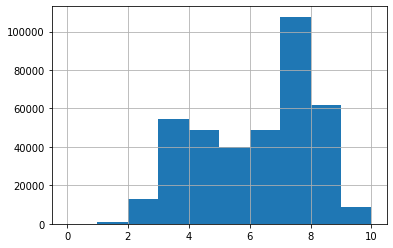

In [7]:
# Get Na counts: by feature, by sample
na_ft_train, na_sp_train = analyze_train.get_na_counts()
na_ft_test, na_sp_test = analyze_test.get_na_counts()
if PRINT_ON:
    print('Train: NaNs count by feature\n\n', na_ft_train[na_ft_train!=0])
    print('\n\nTest: NaNs count by feature\n\n', na_ft_test[na_ft_test!=0])


# Analyze NaN distribution by sample
# ie. when a sample has NaNs, it has 5 NaNs most frequently
if PLOT_ON:
    na_sp_train.hist()
    _ = plt.plot()

### Gender NaNs

- train: 1 missing
- test: 1 missing

#### Remarques
- according to group_composition_label, its a man

#### Conclusion
- => Replace by man

In [8]:
# Get samples with Gender NaN
gender_na = analyze_train.df[analyze_train.df['gender'].isna()]

# > Replace NaN by male
analyze_train.df.loc[gender_na.index[0], 'gender'] = 'male'

# Test set: Apply same imputation
# - Not possible since 'individual_role' is NaN
gender_na_test = analyze_test.df[analyze_test.df['gender'].isna()]

# Since the only method is not applicable,
# set whichever default value, say 'male'
analyze_test.df.loc[gender_na_test.index[0], 'gender'] = 'male'

### Pregnancy NaNs

flag representing whether the individual is pregnant (if applicable)	

#### Remarques
- hyp1: mistake in case where child_to_come was registered

#### Conclusion
- => use the value of child_to_come is any

In [26]:
# Get samples with Pregnancy NaN
pregnancy_na = analyze_train.df[analyze_train.df['pregnancy'].isna()]
pregnancy_na['child_to_come']

#mask_pregnancy_na = analyze_train.df == analyze_train.df['pregnancy'].isna()
# Individual_role
# Hyp: a child can't be pregnant.
#mask_pregnancy_na_child = pregnancy_na['individual_role'] == 'child'


individual_id
26f4f45b151ecd4c10f2b3eb4374d51a      f
26f4f45b151ecd4c10f2b3eb4374d51a      f
26f4f45b151ecd4c10f2b3eb4374d51a      f
31babb0ec972e3502312b15ef77abdec    NaN
26f4f45b151ecd4c10f2b3eb4374d51a      f
a2aeb6efde9c45ef9501310b2236a43f    NaN
a2aeb6efde9c45ef9501310b2236a43f    NaN
f119ed12c28ca9a191679e5e7539c05f    NaN
544c66ba16fd3a1490ff5b03e10c1840    NaN
9dbef2aa1a1242ce2feabbc47d36138e      f
a2aeb6efde9c45ef9501310b2236a43f    NaN
a1e7dba37a4926bd9c545416ad24ac18      f
a2aeb6efde9c45ef9501310b2236a43f    NaN
e4e7b995f80a7f211f6b213b073710f0      f
Name: child_to_come, dtype: object

In [29]:
#mask_pregnancy_na = df.mask(df['pregnancy'].isna())
df.mask(df['pregnancy'].isna() and df['child_to_come'])

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

#### Explore impact on target

Results: there seems not to have a significative direct correlation with target

In [ ]:
# Summary of target counts:
# ± half individuals granted >=1 night(s)
# which means < 50% of requests
# Rq: still nicely balanced dataset
target_counts = analyze_train.df[target].value_counts()

if PRINT_ON:
    print('Absolute\n', target_counts)
    print('\n\nPercentage\n', target_counts / n_samples * 100)

# Filter pregnants
mask_pregnant = analyze_train.df['pregnancy'] == True

# Count pregnants: 11k+ pregnant
n_pregnants = sum(mask_pregnant)

# Percentage ± 3%
pct_pregnants = n_pregnants/ n_samples * 100


# Correlation target & pregnancy: ± -.1% (significant? not)
analyze_train.df[[target, 'pregnancy']].corr()

# Summary
target_pregnancy_counts = analyze_train.df[target].groupby(analyze_train.df['pregnancy']).value_counts()

if PRINT_ON:
    # Pct pregnants by target
    print('\n\nN of nights granted for pregnants', target_pregnancy_counts[1] / n_pregnants)
    # Pct not pregnants by target
    print('\nN of nights granted for not pregnants', target_pregnancy_counts[0] / (n_samples - n_pregnants))

# => Repartitions are similar

#### Pattern for missing pregnancy?
Search if missing is treated as pregnant through correlated variables

In [ ]:
analyze_train.df['gender'].groupby(analyze_train.df['pregnancy']).value_counts()

In [ ]:
# Pattern with child_situation
analyze_train.df[target].groupby(analyze_train.df['pregnancy']).value_counts()

In [ ]:
# Requests granted (nb_nights > 0)
granted = analyze_train.df[target] > 0


## child_to_come

flag indicating whether the group is expecting a baby


What does it represent?

- hyp: it is the corresponding value of the individual "pregnancy"

Then?

- now that dataframes are joined, it is redondant

Conclusion

- use it to impute pregnancy NAs

- then drop the feature

# Outliers

## Gender

Only females are possibly pregnant, thus 30 males have made a mistake

In [ ]:
analyze_train.df['gender'].groupby(analyze_train.df['pregnancy']).value_counts()

In [ ]:
# Retrieve the individual ids, and correct for male -> pregnancy = 0

# Analyze data

## Analysis (df_train)
### General:
- Number of requests: 238191
- Number of individuals: 384133
- Number of features: 39

Requests are made for 1.6 pers on average.


### Correlations with granted_number_of_nights
- housing_situation_id: -0.458581. Strong negative impact. A high value must represent the good quality of the current housing situation.
- housing_situation_2_id: 0.283840. Strong positive impact. A higher value must conversely represent a degraded quality.

### Principal components
- housing_situation_2_label: with value "emergency accomodation". High probability to get 1 or two nights.

In [ ]:
Analyze_df_train = Analysis(df_train)
#Analyze_df_train.describe(investigation_level=3)
#Analyze.visualize()

In [ ]:
target = 'granted_number_of_nights'
feature = 'animal_presence'
mask = df_train[feature] == 't'
df_train[mask][[feature, target]]

In [ ]:
# Check for NA, inf
columns_selected = ['animal_presence']
df_train[columns_selected].isnull().sum()
df_train.isnull().sum()

## Analysis of features

feature: housing_situation_2_label
- A majority of requests with the label "emergency accomodation" obtains 1 or 2 nights.

In [ ]:
# Impact of feature on target
join_key = 'request_id'
target = 'granted_number_of_nights'
feature = 'housing_situation_2_label'
mask = df_train[feature] == 'emergency accomodation'

# Hist: drop duplicate requests (due to indiv data merged)
df_train[mask][[join_key, target]].drop_duplicates().hist()
plt.show()

## Transform categorical features
Prepare data to feed models

- booleans: replace by (1, 0)

- 2 < cats < 11: one-hot encoding

- No transform on features with more than 11 categories

In [ ]:
# Pre-process columns:
# booleans: 't', 't' => True, False
# Categorical with few classes => one-hot encoding
bools_train, failed_train = analyze_train.transform_categories(target=analyze_train.target)
bools_test, failed_test = analyze_test.transform_categories(target=analyze_test.target)

# Preprocess specific cat columns
analyze_train.convert_to_bool(col='group_type',
                            true_val='group',
                            false_val='individual')

# Preprocess specific cat columns
analyze_test.convert_to_bool(col='group_type',
                            true_val='group',
                            false_val='individual')

# Export data
analyze_train.export_data('data/data_train_preprocessed.csv')
analyze_test.export_data('data/data_test_preprocessed.csv')

# Predict

## Build models

### Benchmarks

In [ ]:
# Random uniform train/test
random_preds_train = np.random.uniform(size=(requests_train.shape[0], 4))
random_preds_test = np.random.uniform(size=(requests_test.shape[0], 4))

# Dumb (always pred 3)
dumb_preds_train = np.zeros((requests_train.shape[0], 4))
dumb_preds_test = np.zeros((requests_test.shape[0], 4))
# Set 10% pred everywhere (if not, log penalyzes hardly)
dumb_preds_train[:,:] = .01
dumb_preds_test[:,:] = .01
# Set 20% pred on class 3
dumb_preds_train[:,2] = .02
dumb_preds_test[:,2] = .02

### Univariate predictions

We observed a significant (negative) correlation of housing_situation_id with granted_number_of_nights, let's train a univariate model


In [ ]:
# Set model' parameters
clf = tree.DecisionTreeClassifier(
    criterion='gini',
    splitter='best',
    max_depth=2,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=None,
    max_leaf_nodes=None,
    class_weight=None)

# Build train/test datasets with housing_situation_id only
X_train = np.array(requests_train['housing_situation_id']).reshape(-1, 1)
X_test = np.array(requests_test['housing_situation_id'].values).reshape(-1, 1)
Y_train = requests_train.granted_number_of_nights.values
Y_test = requests_test.granted_number_of_nights.values

# Transform categorical target into a one-hot vector
Y_train_onehot = to_onehot(Y_train)
Y_test_onehot = to_onehot(Y_test)

# Train the model
clf = clf.fit(X_train, Y_train_onehot)

# Yield train/test predictions
preds_train_tree_univar = clf.predict(X_train)
preds_test_tree_univar = clf.predict(X_test)

# Fill predictions to .2 elsewhere
preds_train_tree_univar[preds_train_tree_univar == 0] = .2
preds_test_tree_univar[preds_test_tree_univar == 0] = .2

# Evaluate train/test
score_train = competition_scorer(Y_train, preds_train_tree_univar)
score_test = competition_scorer(Y_test, preds_test_tree_univar)

# Display results
print(f'train score: {score_train:.2f}')
print(f'test score: {score_test:.2f}')

In [ ]:
probas = clf.predict_proba(X_train)
v0 = probas[0].max(1)
v1 = probas[1].max(1)
v2 = probas[2].max(1)
v3 = probas[3].max(1)

## Evaluate models

In [ ]:
y_true_test = requests_test.granted_number_of_nights.values

# Evaluate benchmarks
random_score_test = competition_scorer(y_true_test, random_preds_test)
dumb_score_test = competition_scorer(y_true_test, dumb_preds_test)

# Display results
print(f'test score random: {random_score_test:.2f}')
print(f'test score dumb: {dumb_score_test:.2f}')

### Train set

In [ ]:
y_true_train = requests_train.granted_number_of_nights.values

# Evaluate benchmarks
random_score_train = competition_scorer(y_true_train, random_preds_train)
dumb_score_train = competition_scorer(y_true_train, dumb_preds_train)

# Display results
print(f'train score random: {random_score_train:.2f}')
print(f'train score dumb: {dumb_score_train:.2f}')

### Test set

## Interpret models

In [ ]:
# Tree
fn = ['housing_situation_id']
cn = ['0', '1', '2', '3']

tree.plot_tree(clf,
               feature_names = fn, 
               class_names=cn,
               filled = True)

requests_train['housing_situation_id'].hist()